In [105]:
import base

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import SVC

from transformers_sig import AddTime, LeadLag
from sigKer_fast import mmd_distance

In [55]:
import os
path = '../data/TracerX/'
files = []
outcome_df = pd.read_json('../data/TracerX/outcome.fullCohort.json')
y = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and 'CRUK' in i:
        patient_id = i[:8]
        files.append(path + i)
        y.append(outcome_df[outcome_df.ID == patient_id].outcome.values[0])

In [17]:
dataframes = []
for file in tqdm(files):
    dataframes.append(pd.read_json(file).T)

In [18]:
trees = []
for df in tqdm(dataframes):
    trees.append([np.array([list(d.values()) for d in df.iloc[:,k].values]).T for k in range(len(df.columns))])

In [637]:
X = []
masks = []

for t in tqdm(trees):
    
    # find max length of the given tree
    max_len_tree = 0
    for d in t:
        if d.shape[0]>max_len_tree:
            max_len_tree = d.shape[0]
            
    # eliminate channels that end with 0 in all branches
    mask = t[0][-1,:] != 0
    for d in t[1:]:
        mask_ = d[-1,:] !=0
        mask = [i and j for i,j in zip(mask,mask_)]
    masks.append(mask)
        
    # pad all branches to max length
    tree = []
    for d in t:
        len_to_pad = max_len_tree - d.shape[0]
        branch = np.concatenate([d,np.repeat(d[-1,np.newaxis,:], len_to_pad, axis=0)],axis=0)
        tree.append(branch)
    
    tree = np.array(tree, dtype=np.float64)
#     tree = TimeSeriesScalerMinMax().fit_transform(tree)
#     tree = TimeSeriesScalerMeanVariance().fit_transform(tree)
    X.append(tree)

In [639]:
final_mask = masks[0]
for m in masks[1:]:
    final_mask = [i and j for i,j in zip(final_mask, m)]

In [641]:
for m in final_mask:
    if m:
        print('hi')

In [630]:
mask = X[0][2][-1,:]!=0
mask_ = X[0][1][-1,:]!=0

In [642]:
# [i and j for i,j in zip(mask,mask_)]

tree shape: (3, 5, 16450)
class: 0


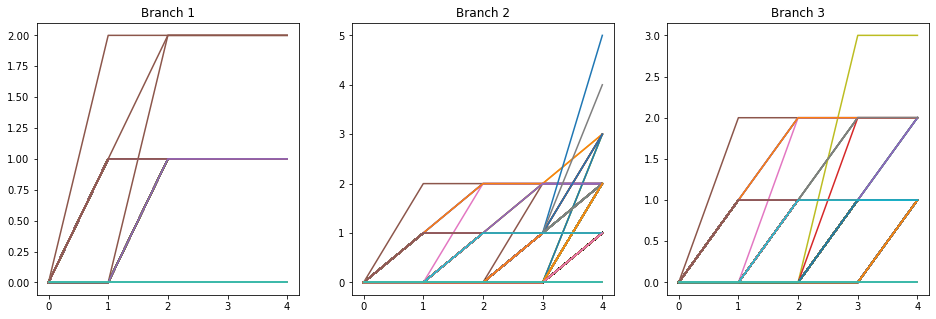

In [644]:
i = 0
l_i = X[i].shape[0]
print(f'tree shape: {X[i].shape}')
print(f'class: {y[i]}')
fig, ax = plt.subplots(1,l_i,figsize=(16,5))
for j in range(l_i):
    ax[j].plot(X[i][j][:,:])
    ax[j].set_title(f'Branch {j+1}')
plt.show()

In [536]:
# train test split
ind_train, ind_test, y_train, y_test = train_test_split(np.arange(len(y)), y, test_size=.3, stratify=y)

In [537]:
# def mmd_distance_(t_i, t_j, sigma):
#     return mmd_distance(t_i, t_j, n=1, solver=1, rbf=False, sigma=sigma)

In [538]:
def create_mmd_distance_matrix(trees, scale=4e-2, n=0, solver=0, rbf=False, sigma=1e-3):
    N = len(trees)
    K_full = np.zeros((N,N))
#     indices = np.triu_indices(N, k=0, m=N)
#     K_full[indices] = Parallel(n_jobs=1,verbose=5)(
#         delayed(mmd_distance_)(trees[i], trees[j], sigma)
#         for i in range(N)
#         for j in range(i,N)
#     )
    for i in trange(N, desc='1st loop'):
        for j in trange(i,N, desc='2nd loop', leave=False):
            K_full[i,j] = mmd_distance(scale*trees[i], scale*trees[j], n=n, solver=solver, rbf=rbf, sigma=sigma) 

    indices = np.tril_indices(N, k=-1, m=N)
    K_full[indices] = K_full.T[indices]
    return K_full

In [539]:
K_full = create_mmd_distance_matrix(X)

In [540]:
# y

In [541]:
np.round(K_full,3)

array([[ 0.   , 18.841, 19.294, ..., 24.285, 20.602, 25.86 ],
       [18.841,  0.   ,  2.505, ...,  8.068,  3.976,  9.99 ],
       [19.294,  2.505,  0.   , ...,  8.422,  4.424, 10.243],
       ...,
       [24.285,  8.068,  8.422, ...,  0.   ,  9.756, 14.404],
       [20.602,  3.976,  4.424, ...,  9.756,  0.   , 11.46 ],
       [25.86 ,  9.99 , 10.243, ..., 14.404, 11.46 ,  0.   ]])

In [542]:
class TreeKernel(BaseEstimator, TransformerMixin):
    def __init__(self, K_full=None, sigma=1.0):
        super(TreeKernel, self).__init__()
        self.K_full = K_full
        self.sigma = sigma

    def transform(self, ind):
        return np.exp(-self.K_full[ind][:,self.ind_train]/self.sigma)

    def fit(self, ind, y=None, **fit_params):
        self.ind_train = ind
        return self

In [589]:
# parameters for grid search
parameters = {'tree__sigma': np.logspace(-4, 4, 9),
              'clf__kernel': ['precomputed'],
              'clf__gamma': np.logspace(4, 4, 9), 
              'clf__C': np.logspace(0, 4, 5)
              }

In [597]:
# estimator: support vector classifier
clf = SVC(class_weight={1:3})

In [598]:
# building the estimator
pipeline = Pipeline([('tree', TreeKernel(K_full=K_full)),
                     ('clf', clf)
                    ])

In [599]:
# parameters search
model = GridSearchCV(pipeline, parameters, verbose=0, n_jobs=-1, cv=5)

In [600]:
# fit the model
model.fit(ind_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree',
                                        TreeKernel(K_full=array([[ 0.        , 18.84110594, 19.29404155, ..., 24.28538096,
        20.60150896, 25.85971139],
       [18.84110594,  0.        ,  2.50540443, ...,  8.06816306,
         3.9763809 ,  9.99043181],
       [19.29404155,  2.50540443,  0.        , ...,  8.42214386,
         4.4241152 , 10.24344474],
       ...,
       [24.28538096,  8.06816306,  8.42214386, ...,  0.        ,
         9.75558385, 14.40387535],
       [20.6...
       [25.85971139,  9.99043181, 10.24344474, ..., 14.40387535,
        11.46031389,  0.        ]]))),
                                       ('clf', SVC(class_weight={1: 3}))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'clf__gamma': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000.]),
                         'clf__k

In [601]:
# best score an 5-folds cross-validation split
model.best_score_

0.7307692307692308

In [602]:
# predict on test set
y_pred = model.predict(ind_test)

In [603]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        20
           1       0.00      0.00      0.00         8

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28

